#### Анализ результатов AB-теста. 2 задание 5 урока. Выполнил Артур Гареев.

In [1]:
# Импортирую библиотеки
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from hashlib import md5 # для бакетного преобразования

%matplotlib inline

In [2]:
# Создаю подключение к кликхаус как в примере
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database': 'simulator_20221020',
    'user': 'student',
    'password': 'dpo_python_2020'
}

In [3]:
# Пишу sql запрос
query = '''
/*
Запрос считает количество лайков, просмотров и CTR для каждого
пользователя в период проведения AB-теста для групп 1 и 2.
*/
SELECT fa.user_id,
    fa.exp_group,
    SUM(action = 'like') AS likes,
    SUM(action = 'view') AS views,
    likes / views AS CTR
FROM {db}.feed_actions as fa
WHERE toDate(fa.time) >= toDate('2022-10-03')
    AND toDate(fa.time) <= toDate('2022-10-09')
    AND fa.exp_group IN (1, 2)
GROUP BY fa.user_id, fa.exp_group
'''
# Записываю результат в переменную result и вывожу первые 5 строк
result = ph.read_clickhouse(query, connection=connection)
result.head()

,user_id,exp_group,likes,views,CTR
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750


In [4]:
# для удобства делю датафрейм на группы
control = result[result['exp_group'] == 1].copy()
treatment = result[result['exp_group'] == 2].copy()
print('Контрольная группа'.center(40))
display(control.head(), control['CTR'].describe())
print('Группа воздействия'.center(40))
display(treatment.head(), treatment['CTR'].describe())

           Контрольная группа           


,user_id,exp_group,likes,views,CTR
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750


count    10079.000000
mean         0.215605
std          0.084160
min          0.000000
25%          0.160097
50%          0.203125
75%          0.257654
max          0.722222
Name: CTR, dtype: float64

           Группа воздействия           


,user_id,exp_group,likes,views,CTR
5,131473,2,14,134,0.104478
6,23985,2,7,87,0.080460
7,24523,2,11,101,0.108911
8,32420,2,26,128,0.203125
9,24239,2,40,90,0.444444


count    9952.000000
mean        0.214419
std         0.144180
min         0.000000
25%         0.095238
50%         0.142857
75%         0.325000
max         0.923077
Name: CTR, dtype: float64

В данных есть некоторые различия, хоть средние значения и близки, процентили CTR заметно различаются, к тому же стандартное отклонение в группе воздействия сильно выше. Визуализируем CTR в группах для визуальной оценки.

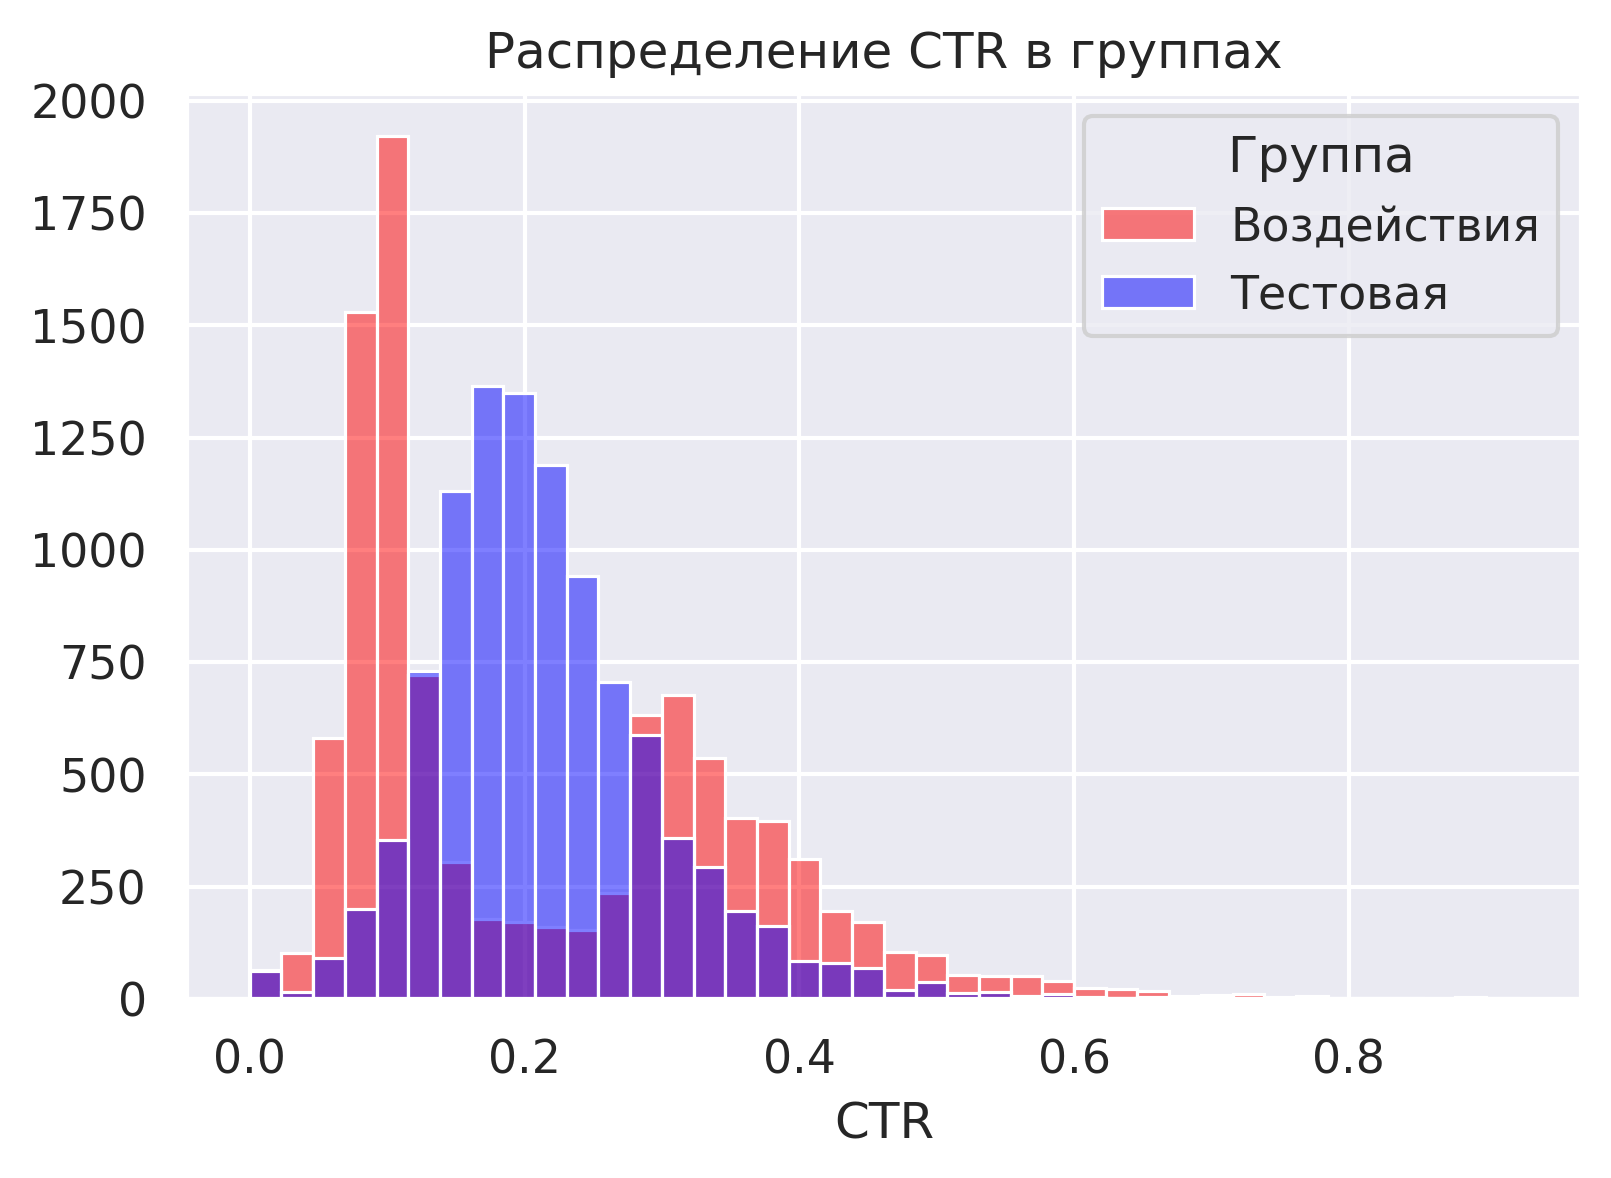

In [5]:
# Посмотрю на гистограммы распределения CTR по группам
sns.set_theme()
fig, ax = plt.subplots(dpi=300)
sns.histplot(result, x='CTR', hue='exp_group', bins=40,
             palette=['blue', 'red'], alpha=0.5, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('CTR')
plt.title('Распределение CTR в группах')
plt.legend(title='Группа', labels=['Воздействия', 'Тестовая'])
plt.show()

#### T-test VS Mann-Whitney

На графике видно, что CTR пользователей treatment группы имеет бимодальное распределение, в то время как CTR в тестовой группе распределился относительно нормально. Думаю, что в данном случае не стоит ждать хороших результатов от t-теста и здесь лучше себя покажет U-критерий Манна-Уитни.

Сравним результаты данных тестов.

In [6]:
# Сравниваю CTR групп стат. тестами и вывожу результаты
tt_pvalue = st.ttest_ind(treatment['CTR'], control['CTR'],
                            equal_var=False).pvalue

mw_pvalue = st.mannwhitneyu(treatment['CTR'], control['CTR']).pvalue
print('Результаты тестов'.center(50), '-' * 50,
      f'      T-test pvalue: {tt_pvalue}',
      f'Mann-Whitney pvalue: {mw_pvalue}', sep='\n')

                Результаты тестов                 
--------------------------------------------------
      T-test pvalue: 0.4780623130874935
Mann-Whitney pvalue: 6.0376484617779035e-56


Как и ожидалось, тест Манна-Уитни показал себя лучше t-теста, последний, к слову, не обнаружил статистически значимых различий между группами, но это не значит, что t-тест плох, просто в данном случае не соблюдаются условия его применения.

#### Сравнение сглаженных CTR

In [7]:
# создаю функцию сглаживания метрики CTR
def CTR_smooth(likes, views, global_CTR, alpha):
    '''
    Функция сглаживающая метрику CTR
    
    Аргументы
    ---------
    likes - количество лайков
    views - количество просмотров
    global_CTR - глобальный CTR по группе
    alpha - гиперпараметр, задается произвольно
    
    Возвращает Series со сглаженными метриками CTR
    '''
    return (likes + alpha * global_CTR) / (views + alpha)

In [8]:
# Считаю глобальные CTR по группам
treatment_global_CTR = treatment['likes'].sum() \
    / treatment['views'].sum()

control_global_CTR = control['likes'].sum() \
    / control['views'].sum()
# Считаю сглаженные CTR по группам
treatment['smooth_CTR'] = treatment.apply(
    lambda x: CTR_smooth(x['likes'], x['views'],
                         treatment_global_CTR, alpha=5), axis=1);

control['smooth_CTR'] = control.apply(
    lambda x: CTR_smooth(x['likes'], x['views'],
                         control_global_CTR, alpha=5), axis=1)

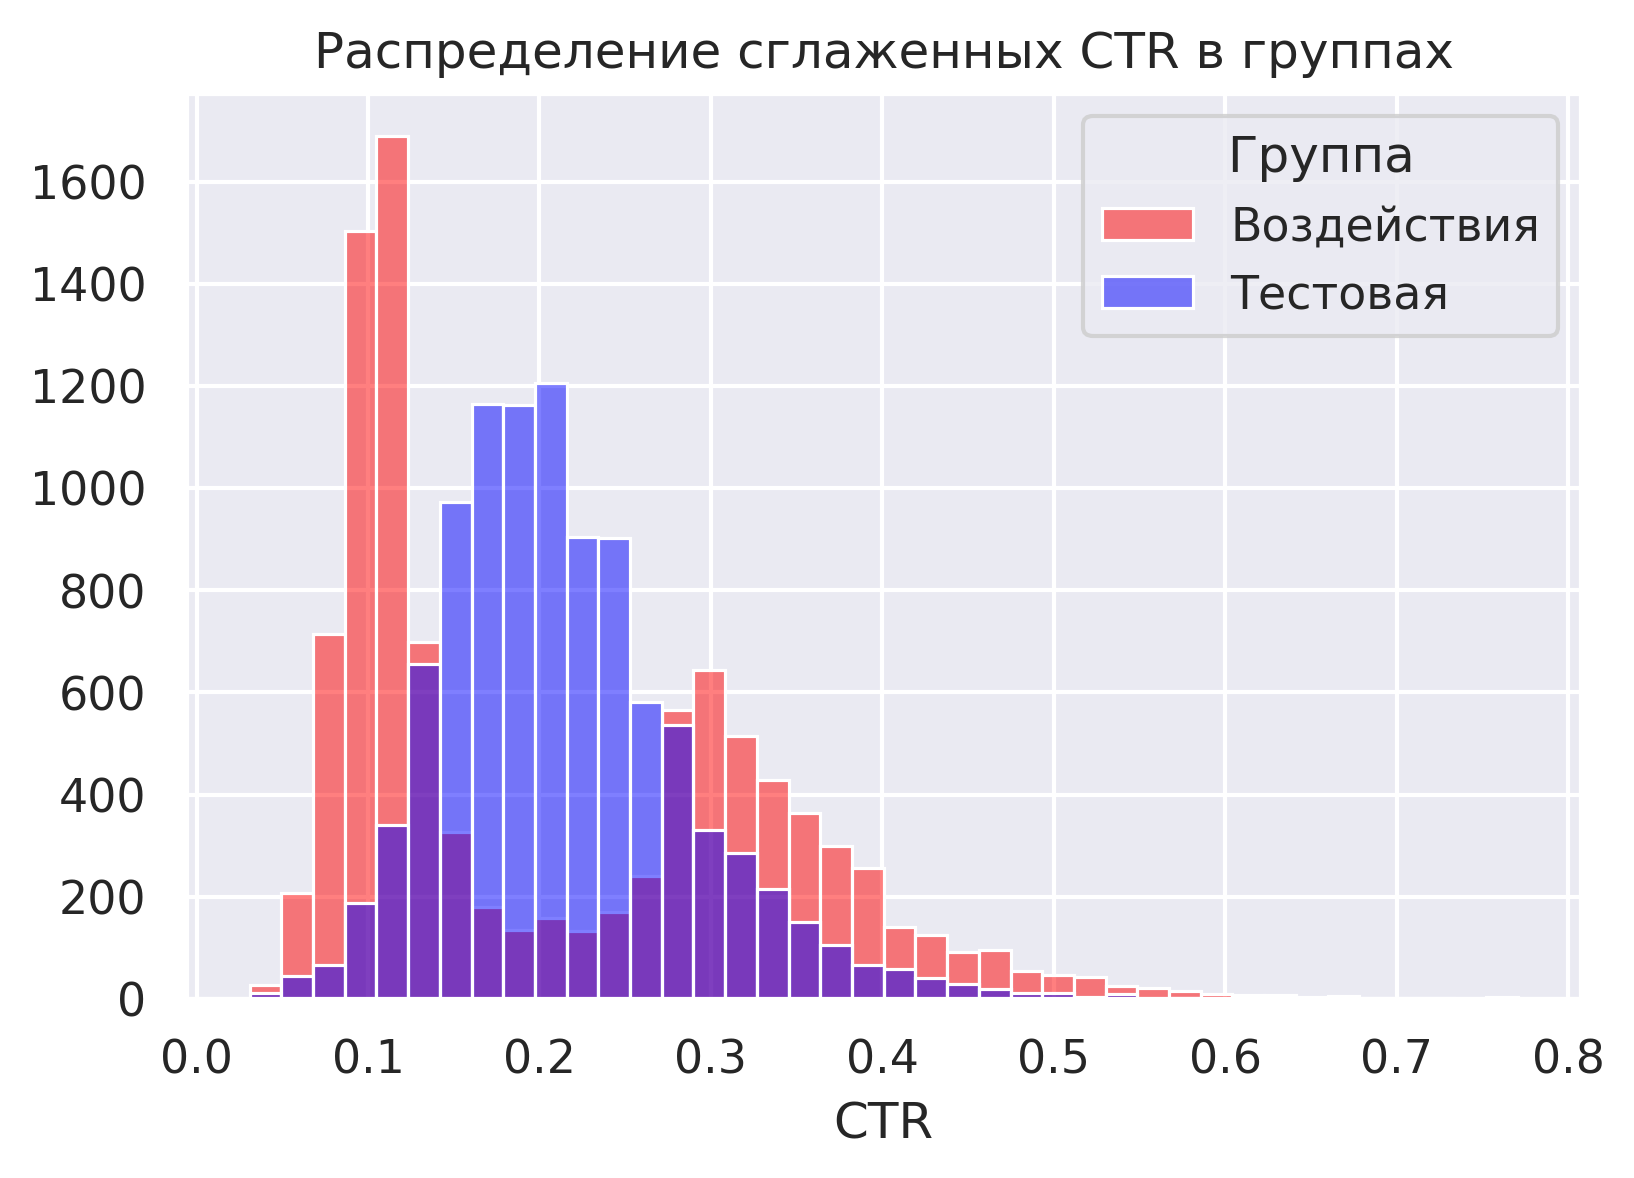

In [9]:
# Посмотрю на гистограммы распределения сглаженных CTR по группам
fig, ax = plt.subplots(dpi=300)
sns.histplot(pd.concat([control, treatment]), x='smooth_CTR', hue='exp_group', bins=40,
             palette=['blue', 'red'], alpha=0.5, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('CTR')
plt.title('Распределение сглаженных CTR в группах')
plt.legend(title='Группа', labels=['Воздействия', 'Тестовая'])
plt.show()

Визуально видны небольшие отличия распределения сглаженных CTR относительно классической метрики, не уверен, что это сильно повлияет на результаты тестов, проверим.

In [10]:
# Сравниваю сглаженные CTR групп
tt_pvalue = st.ttest_ind(treatment['smooth_CTR'], 
                         control['smooth_CTR'],
                         equal_var=False).pvalue

mw_pvalue = st.mannwhitneyu(treatment['smooth_CTR'], 
                            control['smooth_CTR']).pvalue

print('Результаты тестов'.center(50), '-' * 50,
      f'      T-test pvalue: {tt_pvalue}',
      f'Mann-Whitney pvalue: {mw_pvalue}', sep='\n')

                Результаты тестов                 
--------------------------------------------------
      T-test pvalue: 0.0223769815558559
Mann-Whitney pvalue: 1.6163964114270227e-61


В случае сравнения сглаженной метрики CTR t-тест показывает себя на порядок лучше и при уровне принятия решения 0.05 мы могли бы отклонить нулевую гипотезу о равенстве средних, но если бы мы приняли альфа равным 0.01, то у нас бы не было достаточно оснований для этого. Тест Манна-Уитни, в свою очередь, показывает хорошие результаты и его pvalue стал еще ниже.

#### Пуассоновский бутстреп

In [11]:
# Объявляю функцию для проведения Пуассоновского бутстрепа
def poisson_bootstrap(a_likes, a_views, b_likes, b_views, n_iters=1000):
    '''
    Функция для проведения Пуассоновского бутстрепа
    
    Аргументы
    ---------
    a_likes - количество лайков в группе a
    a_views - количество просмотров в группе a
    b_likes - количество лайков в группе b
    b_views - количество просмотров в группе b
    n_iters - количество итераций
    
    Функция возвращает два массива с глобальными
    CTR для групп a и b
    '''
    a_weight = st.poisson(1).rvs(
        (n_iters, len(a_likes))).astype(np.int64)
    
    b_weight = st.poisson(1).rvs(
        (n_iters, len(b_likes))).astype(np.int64)
    
    a_global_CTR = (a_weight * a_likes).sum(axis=1) /\
        (a_weight * a_views).sum(axis=1)
    
    b_global_CTR = (b_weight * b_likes).sum(axis=1) /\
        (b_weight * b_views).sum(axis=1)
    
    return a_global_CTR, b_global_CTR

In [12]:
a_likes = treatment['likes'].to_numpy()
a_views = treatment['views'].to_numpy()
b_likes = control['likes'].to_numpy()
b_views = control['views'].to_numpy()
# Провожу бутстреп
treatment_poisson_CTR, control_poisson_CTR = poisson_bootstrap(
    a_likes, a_views, b_likes, b_views, n_iters=2000)

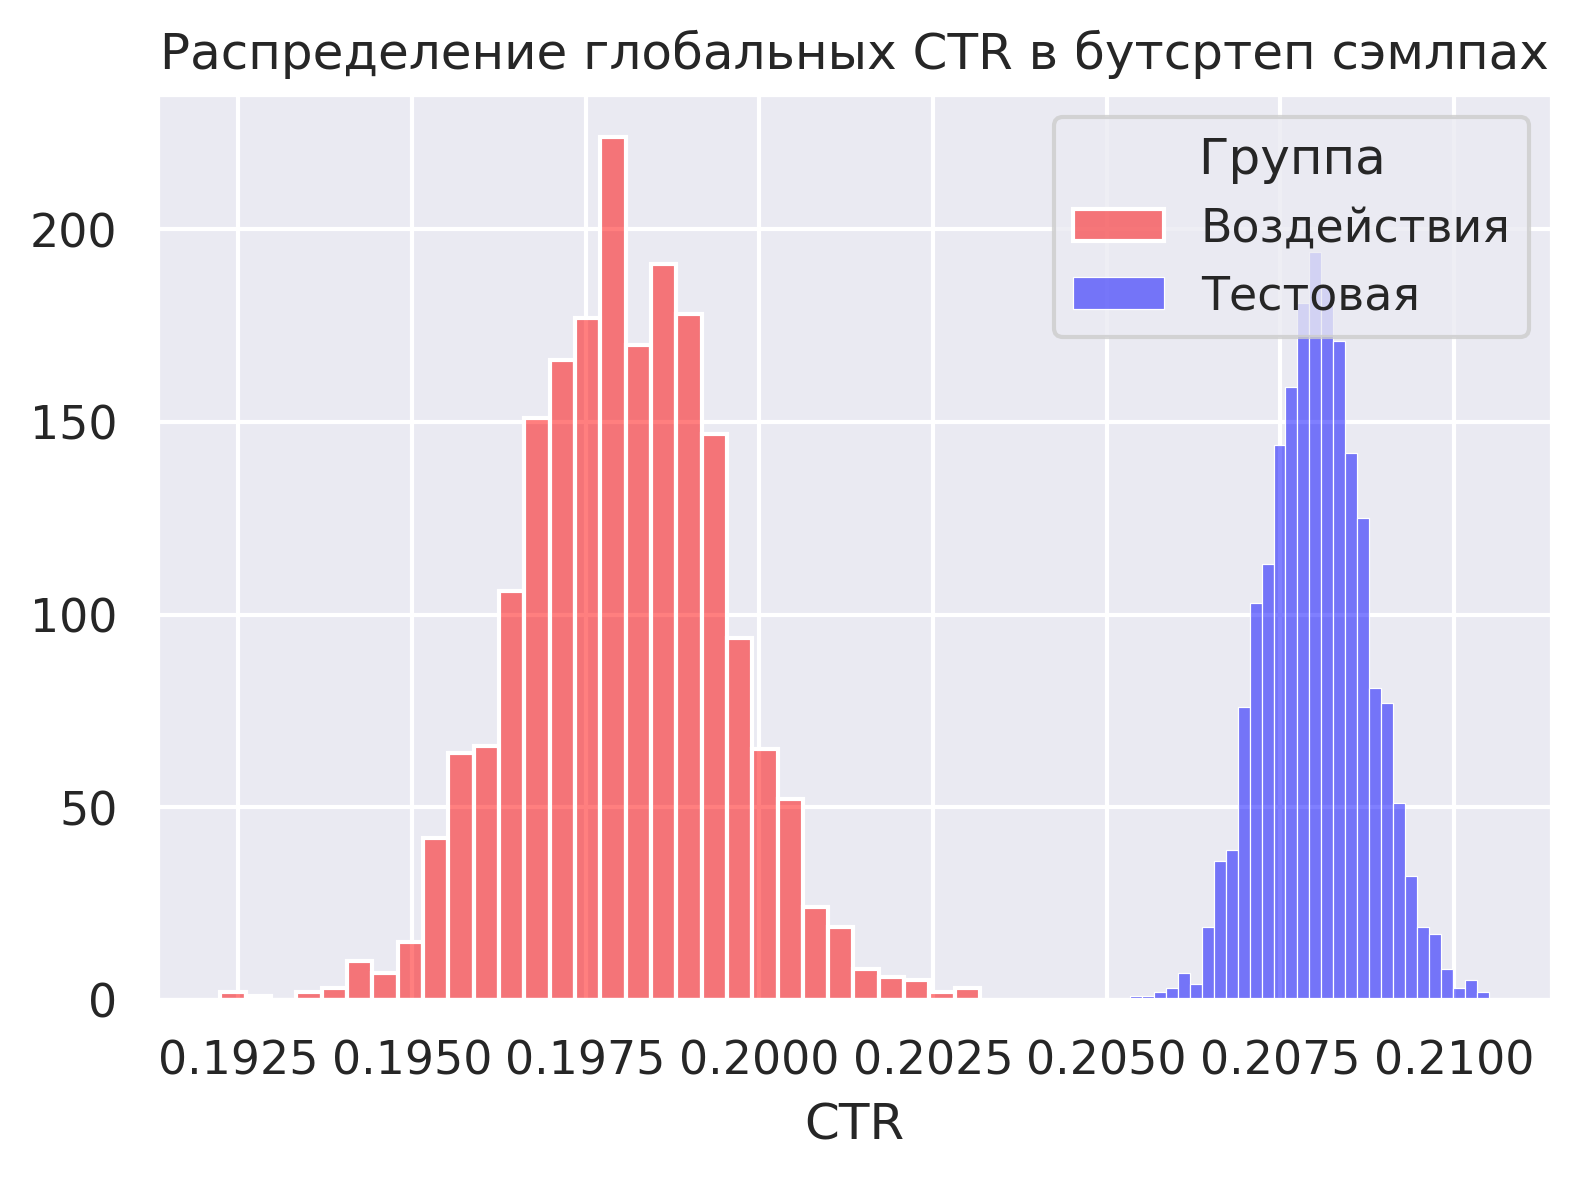

In [13]:
# Посмотрю на гистограммы распределения сглаженных CTR по группам
fig, ax = plt.subplots(dpi=300)
sns.histplot(treatment_poisson_CTR, bins=30,
             color='red', alpha=0.5, ax=ax)

sns.histplot(control_poisson_CTR, bins=30,
             color='blue', alpha=0.5, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('CTR')
plt.title('Распределение глобальных CTR в бутсртеп сэмлпах')
plt.legend(title='Группа', labels=['Воздействия', 'Тестовая'])
plt.show()

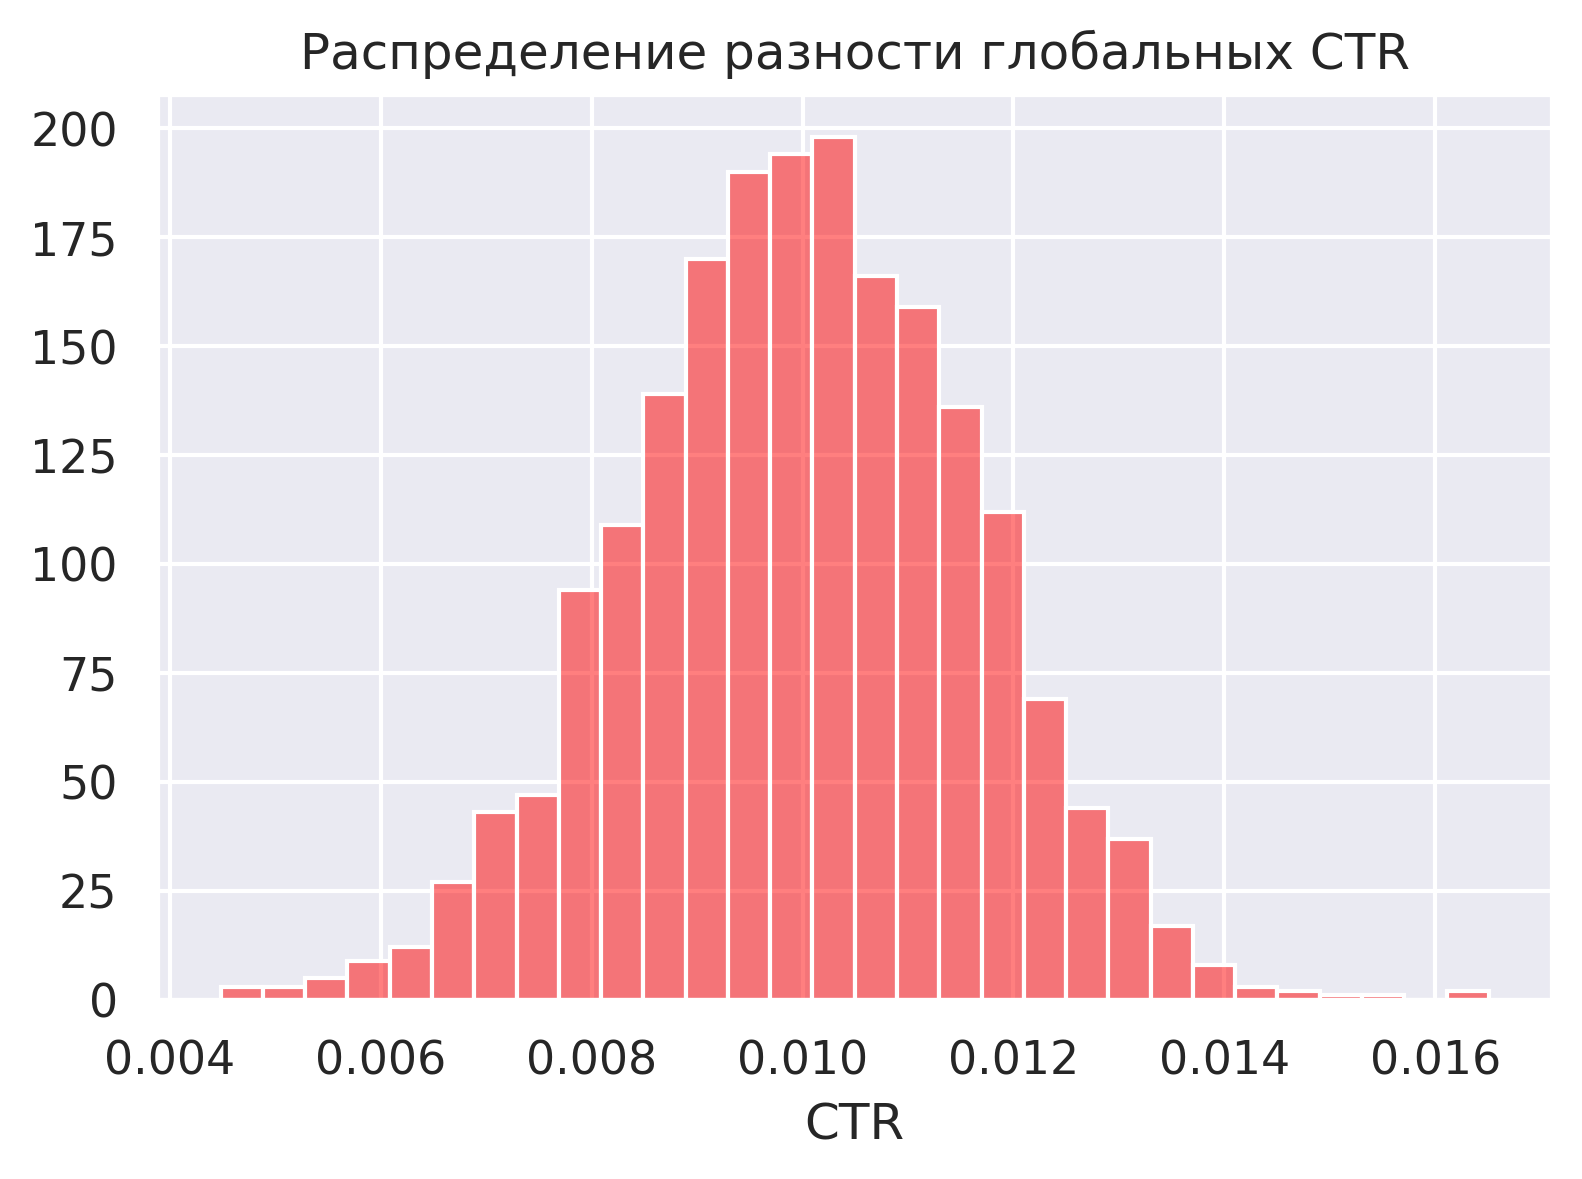

In [14]:
# Посмотрю на распределение разниц между глобальными CTR
fig, ax = plt.subplots(dpi=300)
sns.histplot(control_poisson_CTR - treatment_poisson_CTR,
             bins=30, color='red', alpha=0.5, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('CTR')
plt.title('Распределение разности глобальных CTR')
plt.show()

Распределение разности глобальных CTR не включает ноль, т.е. согласно Пуассоновскому бутстрепу показатели CTR нашей контрольной группы в среднем оказываются выше CTR группы воздействия. Несмотря на низкую скорость работы данного метода, он заслуживает внимания благодаря простоте интерпретации относительно примененных выше тестов.

#### Бакетное преобразование

In [15]:
def get_bucket_number(user_id, salt='default', n_groups=50):
    '''
    Функция для преобразования user_id в номер бакета
    
    Аргументы
    ---------
    user_id - id пользователя
    bucket_salt - соль
    n_groups - количество бакетов
    
    Функция возвращает номер бакета
    '''
    string = str(user_id) + str(salt)
    hash_value = md5(string.encode('ascii')).hexdigest()
    return int(hash_value, 16) % n_groups

In [16]:
# Создаю колонку с номерами бакетов
treatment['bucket'] = treatment.apply(
    lambda x: get_bucket_number(x['user_id']), axis=1)

control['bucket'] = control.apply(
    lambda x: get_bucket_number(x['user_id']), axis=1)
# Считаю CTR в разрезе каждого бакета
treatment_bucket_CTR = (treatment.groupby('bucket')['likes'].sum() /\
    treatment.groupby('bucket')['views'].sum()).values

control_bucket_CTR = (control.groupby('bucket')['likes'].sum() /\
    treatment.groupby('bucket')['views'].sum()).values

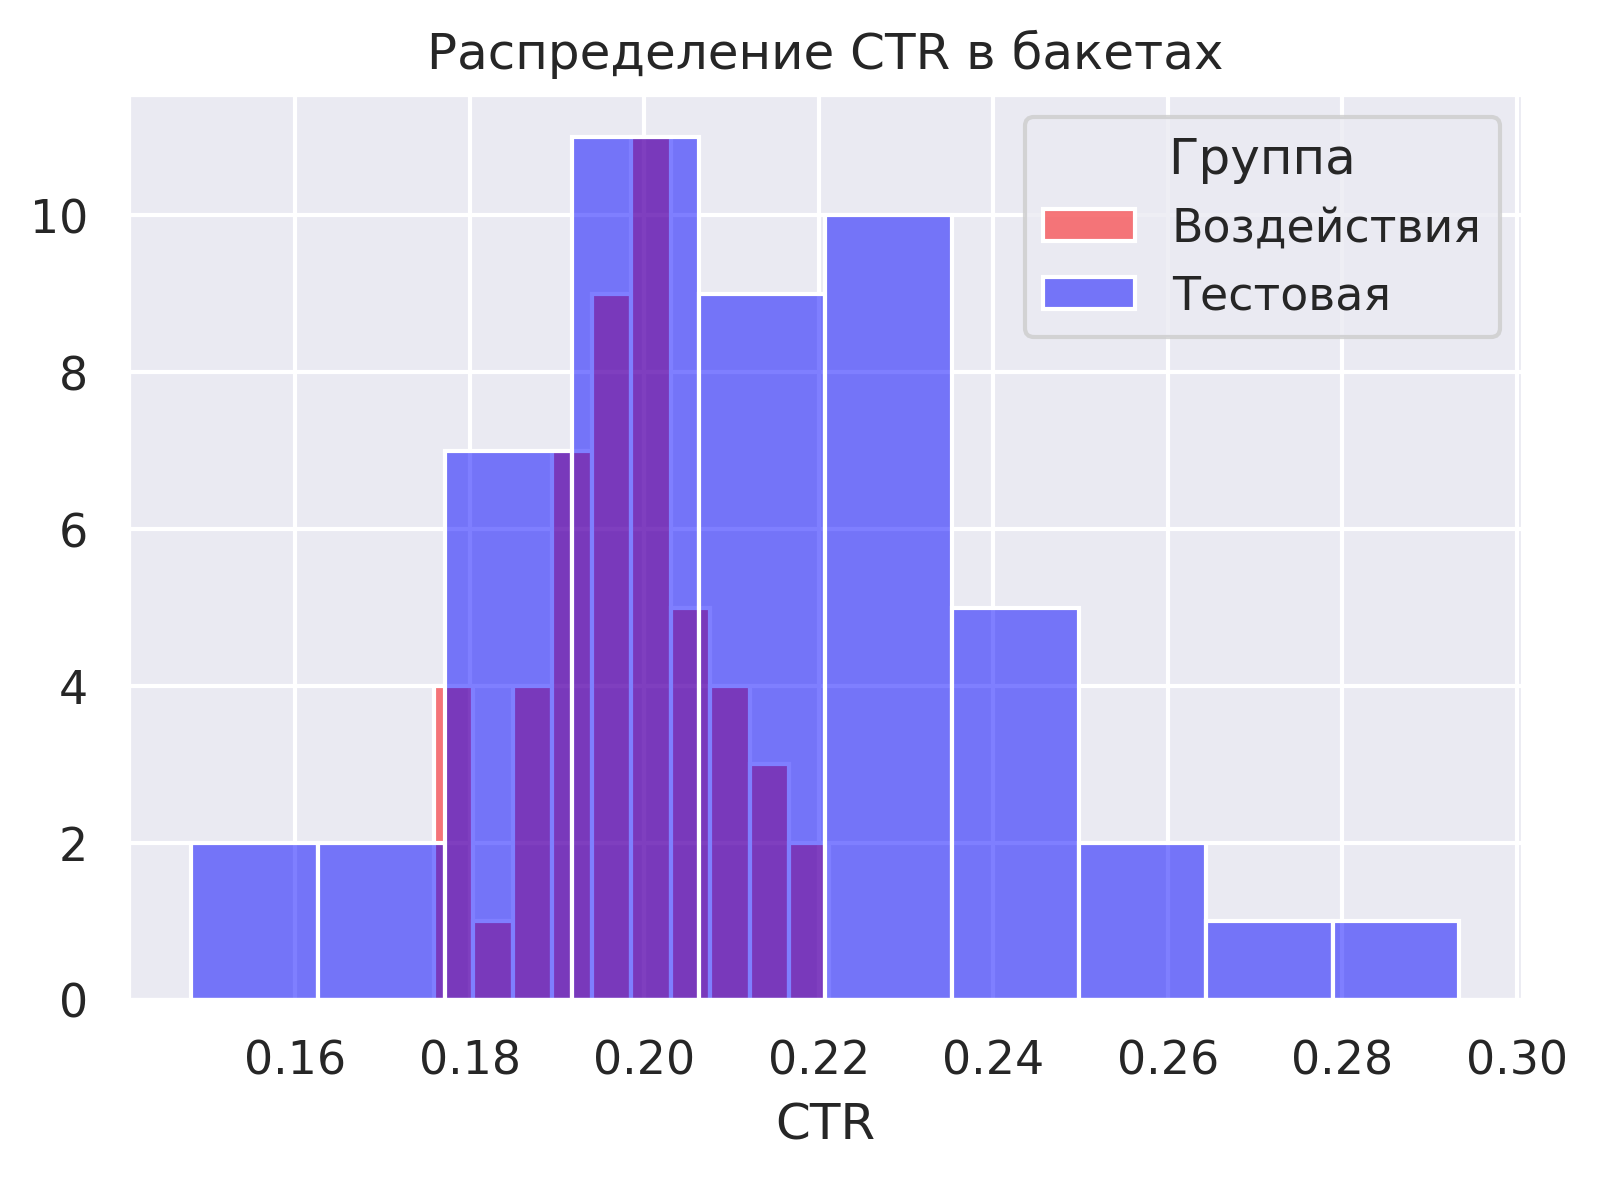

In [17]:
# Посмотрю на гистограммы распределения CTR по бакетам
fig, ax = plt.subplots(dpi=300)
sns.histplot(treatment_bucket_CTR, bins=10,
             color='red', alpha=0.5, ax=ax)

sns.histplot(control_bucket_CTR, bins=10,
             color='blue', alpha=0.5, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('CTR')
plt.title('Распределение CTR в бакетах')
plt.legend(title='Группа', labels=['Воздействия', 'Тестовая'])
plt.show()

Из распределений бакетных CTR видно, что средний CTR группы воздействия ниже среднего CTR в тестовой группе. Можно заметить, что распределение средних CTR по бакетам в группе воздействия стало выглядеть намного лучше, относительно распределения сырой метрики. Статистические тесты должны хорошо справиться с такими данными, проверим.

In [18]:
# Сравниваю побакетные средние CTR
tt_pvalue = st.ttest_ind(treatment_bucket_CTR,
                         control_bucket_CTR,
                         equal_var=False).pvalue

mw_pvalue = st.mannwhitneyu(treatment_bucket_CTR, 
                            control_bucket_CTR).pvalue

print('Результаты тестов'.center(50), '-' * 50,
      f'      T-test pvalue: {tt_pvalue}',
      f'Mann-Whitney pvalue: {mw_pvalue}', sep='\n')

                Результаты тестов                 
--------------------------------------------------
      T-test pvalue: 0.0006568417231953918
Mann-Whitney pvalue: 0.0005891318187221841


Здесь наблюдается интересный результат - оба теста обнаружили статистически значимые различия в группах, при этом pvalue критерия Манна-Уитни стал значительно меньше после бакетного преобразования. Наверное это можно объяснить тем, что критерий Манна-Уитни сравнивает что-то вроде суммы рангов распределений, а так как средние значения CTR в наших группах почти равны и после бакетного преобразования распределения сошлись к средним - то и суммы рангов стали различаться меньше, чем до преобразования.

### Выводы:
- исходя из проведенного AB-теста, я бы категорически **не рекомендовал** катить наш алгоритм, так как он не вызвал ожидаемого роста нашей метрики, к тому же CTR в группе воздействия распределился очень странным образом - возможно прирост метрики на определенных участках обусловлен эффектном новизны и на дольшем горизонте все стало бы ещё хуже;
- можно предположить, что бимодальная форма распределения CTR группы воздействия вызвана тем, что определенной части аудитории все же понравился наш алгоритм, а другой нет (например молодые-взрослые), также возможно, что алгоритм хорошо работает у определенного сегмента пользователей, а у других не очень (например в зависимости от ОС) или просто некоторые пользователи любят изменения, а другие не очень;
- на наших данных очень хорошо себя показал Пуассоновкий бутстреп, т.к. у он хорошо справляется с относительно небольшими выборками, как у нас, и хорошо интерпретируется;
- на мой взгляд бакетное преобразование было бы очень удобно использовать в тех случаях, когда бутстреп не справляется, т.е. когда у нас очень большие выборки, так как это позволяет свести распределение метрики к нормальной и сильно облегчает вычисления;
- классические тесты как всегда хорошо работают, если стараться соблюдать условия их применения, - важно всегда оценить распределения прежде, чем приступать к сравнению.